In [ ]:
!nvidia-smi

Tue Aug 11 04:02:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!git clone https://github.com/NVIDIA/apex /apex
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /apex/.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/lab/SSD/"
gdrive_dir = "/content/gdrive/My Drive/lab/SSD/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
datasets  models  test.zip  train-eval.ipynb  trainval.zip


In [3]:
!unzip -q "/content/gdrive/My Drive/lab/SSD/trainval.zip" -d "/content"
!git clone https://github.com/ncthuan/single-shot-detection-pytorch
!cp single-shot-detection-pytorch/*.py .
!pip install albumentations==0.4.6 -q

Cloning into 'single-shot-detection-pytorch'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 122 (delta 71), reused 80 (delta 33), pack-reused 0
Receiving objects: 100% (122/122), 81.42 KiB | 473.00 KiB/s, done.
Resolving deltas: 100% (71/71), done.
     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 952kB 8.2MB/s 


In [4]:
import os
import time
import torch
import torch.cuda as cuda
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, random_split
from dataset import VOCDataset, collate_fn
from model import SSD300
from loss import MultiBoxLoss
from utils import create_data_lists, clip_gradient, save_checkpoint
from eval_detection_voc import eval_detection_voc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#from apex import amp

## Load dataset

In [ ]:
from utils import create_data_lists
voc07_path = os.path.join('datasets/', 'VOC2007/')
voc12_path = os.path.join('datasets/', 'VOC2012/')
create_data_lists(voc07_path, voc12_path, output_folder='datasets/')


There are 17202 training images. Files have been saved to output_folder: datasets/.

There are 4301 validation images. Files have been saved to output_folder: datasets/.


In [ ]:
!ls datasets/

label_map.json	   TRAIN_objects.json  VAL_objects.json  VOC2012
TRAIN_images.json  VAL_images.json     VOC2007


In [5]:
torch.manual_seed(42)
trainset = VOCDataset(data_folder='datasets/', json_files=('TRAIN_images.json', 'TRAIN_objects.json'), augment=True)
valset = VOCDataset(data_folder='datasets/', json_files=('VAL_images.json', 'VAL_objects.json'))

dataloaders = dict(
    train = DataLoader(trainset, batch_size=32, collate_fn=collate_fn, shuffle=True, num_workers=4),
    val = DataLoader(valset, batch_size=64, collate_fn=collate_fn, shuffle=False, num_workers=4),
)

## EDA

In [ ]:
def visualize_objects_stat(dataset):
    targets = dataset.targets
    objects = list()
    for target in targets:
        objects.extend(target['labels'])
    print('Total number of annotated objects:', len(objects))
    sns.countplot(objects)

In [ ]:
label_map

{'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20,
 'background': 0}

Total number of annotated objects: 49949


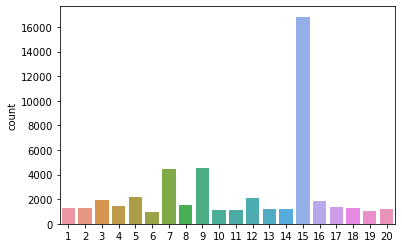

In [ ]:
visualize_objects_stat(trainset)

Total number of annotated objects: 12250


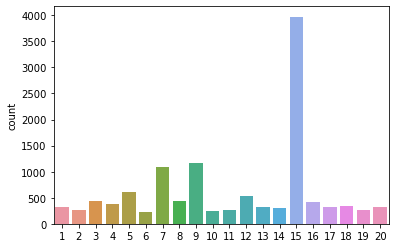

In [ ]:
visualize_objects_stat(valset)

## Train model

In [6]:
device = torch.device("cuda" if cuda.is_available() else "cpu") 

checkpoint_path = gdrive_dir+'models/checkpoint_ssd300.pt'
checkpoint = torch.load(checkpoint_path)
vgg16_dir = 'models/'

MySSD300 = SSD300(n_classes=21, vgg16_dir=vgg16_dir, checkpoint=checkpoint).to(device)

loss_func = MultiBoxLoss(priors_cxcy=MySSD300.get_prior_boxes(), threshold=0.5, neg_pos_ratio=3, alpha=1.)

optimizer = torch.optim.Adam(MySSD300.parameters(), lr=1e-3, weight_decay=5e-4)

exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, last_epoch=-1)

grad_clip = None

# Mixed precision
#MySSD300, optimizer = amp.initialize(MySSD300, optimizer, opt_level='O1')
#if checkpoint: amp.load_state_dict(checkpoint['amp'])

In [7]:
def train_epoch(model, trainset_loader, loss_func, optimizer, epoch_id):
    model.train()
    train_loss = 0
    for step, (imgs, boxes, labels,_) in enumerate(trainset_loader):
        # move input data to GPU
        imgs = imgs.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        
        # forward
        predicted_offsets, predicted_scores = model(imgs)
        loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
        
        # backward & optimize
        optimizer.zero_grad()
        loss.backward()
        #with amp.scale_loss(loss, optimizer) as scaled_loss:
        #    scaled_loss.backward()
        optimizer.step()

        if epoch_id == 1 and step % 100 == 0:
            print(f'Epoch 1 - step {step}: train_loss: {loss.item()/trainset_loader.batch_size:.4f}')
        
        train_loss += loss.item()
        
    return train_loss/len(trainset_loader)

def eval_epoch(model, valset_loader, loss_func):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for step, (imgs, boxes, labels,_) in enumerate(valset_loader):
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            
            predicted_offsets, predicted_scores = model(imgs)
            loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
            val_loss += loss.item()

    return val_loss/len(valset_loader)


def train_model(model, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=1, checkpoint=None):
    last_epoch = 0
    if checkpoint:
        last_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer'].state_dict())
        exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, last_epoch=last_epoch)

    train_loss_hist, val_loss_hist = [], []
    for i in range(last_epoch+1, last_epoch+n_epoch+1):
        start_time = time.time()
        train_loss = train_epoch(model, dataloaders['train'], loss_func, optimizer, i)
        exp_lr_scheduler.step()
        training_time = round(time.time() - start_time)
        
        save_checkpoint(i, model, optimizer, checkpoint_path)
        
        start_time = time.time()
        val_loss = eval_epoch(model, dataloaders['val'], loss_func)
        val_time = round(time.time() - start_time)
        
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        
        print(f'Epoch {i} - train/val_time: {training_time}s | {val_time}s - train_loss: {train_loss:.4f} - val_loss: {val_loss:.4f}')
        
    return train_loss_hist, val_loss_hist

In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=30)

Epoch 1 - step 0: train_loss: 2.8963
Epoch 1 - step 100: train_loss: 0.3581
Epoch 1 - step 200: train_loss: 0.3429
Epoch 1 - step 300: train_loss: 0.3395
Epoch 1 - step 400: train_loss: 0.3645
Epoch 1 - step 500: train_loss: 0.3173
Epoch 1 - step 600: train_loss: 0.3783
Epoch 1 - step 700: train_loss: 0.3241
Epoch 1 - step 800: train_loss: 0.3415
Epoch 1 - step 900: train_loss: 0.3448
Epoch 1 - step 1000: train_loss: 0.3452
Epoch 1 - train/val_time: 661s | 60s - train_loss: 0.3622 - val_loss: 0.3497
Epoch 2 - train/val_time: 662s | 61s - train_loss: 0.3346 - val_loss: 0.3275
Epoch 3 - train/val_time: 661s | 61s - train_loss: 0.3203 - val_loss: 0.3136
Epoch 4 - train/val_time: 666s | 61s - train_loss: 0.3089 - val_loss: 0.3073
Epoch 5 - train/val_time: 660s | 61s - train_loss: 0.2981 - val_loss: 0.3018
Epoch 6 - train/val_time: 662s | 60s - train_loss: 0.2891 - val_loss: 0.2827
Epoch 7 - train/val_time: 660s | 61s - train_loss: 0.2819 - val_loss: 0.2740
Epoch 8 - train/val_time: 658s | 

In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=30, checkpoint=checkpoint)

Epoch 31 - train/val_time: 661s | 59s - train_loss: 0.2304 - val_loss: 0.2289
Epoch 32 - train/val_time: 663s | 58s - train_loss: 0.2294 - val_loss: 0.2313
Epoch 33 - train/val_time: 657s | 58s - train_loss: 0.2287 - val_loss: 0.2241
Epoch 34 - train/val_time: 650s | 58s - train_loss: 0.2278 - val_loss: 0.2265
Epoch 35 - train/val_time: 652s | 58s - train_loss: 0.2266 - val_loss: 0.2325
Epoch 36 - train/val_time: 654s | 58s - train_loss: 0.2258 - val_loss: 0.2336
Epoch 37 - train/val_time: 659s | 58s - train_loss: 0.2256 - val_loss: 0.2265
Epoch 38 - train/val_time: 650s | 58s - train_loss: 0.2244 - val_loss: 0.2305
Epoch 39 - train/val_time: 653s | 58s - train_loss: 0.2240 - val_loss: 0.2214
Epoch 40 - train/val_time: 658s | 58s - train_loss: 0.2228 - val_loss: 0.2245
Epoch 41 - train/val_time: 661s | 58s - train_loss: 0.2221 - val_loss: 0.2325
Epoch 42 - train/val_time: 670s | 59s - train_loss: 0.2210 - val_loss: 0.2269
Epoch 43 - train/val_time: 686s | 60s - train_loss: 0.2211 - val

**The scale of x16 in loss from epoch 61 is due to the change in the train and eval function that return loss values.**<br>
The loss is now not divided by the number of data points but instead, divided by the number of batches

In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 61 - train/val_time: 681s | 61s - train_loss: 3.3478 - val_loss: 3.3572
Epoch 62 - train/val_time: 673s | 60s - train_loss: 3.3390 - val_loss: 3.3421
Epoch 63 - train/val_time: 666s | 61s - train_loss: 3.3367 - val_loss: 3.3296
Epoch 64 - train/val_time: 661s | 60s - train_loss: 3.3233 - val_loss: 3.3309
Epoch 65 - train/val_time: 662s | 60s - train_loss: 3.3108 - val_loss: 3.4230
Epoch 66 - train/val_time: 661s | 60s - train_loss: 3.3005 - val_loss: 3.4096
Epoch 67 - train/val_time: 666s | 60s - train_loss: 3.3068 - val_loss: 3.3156
Epoch 68 - train/val_time: 660s | 60s - train_loss: 3.2905 - val_loss: 3.4187
Epoch 69 - train/val_time: 662s | 60s - train_loss: 3.2836 - val_loss: 3.2860
Epoch 70 - train/val_time: 671s | 60s - train_loss: 3.2768 - val_loss: 3.4145


In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=29, checkpoint=checkpoint)

Epoch 71 - train/val_time: 655s | 61s - train_loss: 3.2639 - val_loss: 3.3308
Epoch 72 - train/val_time: 660s | 60s - train_loss: 3.2714 - val_loss: 3.2807
Epoch 73 - train/val_time: 661s | 60s - train_loss: 3.2602 - val_loss: 3.2868
Epoch 74 - train/val_time: 658s | 60s - train_loss: 3.2541 - val_loss: 3.2680
Epoch 75 - train/val_time: 660s | 60s - train_loss: 3.2462 - val_loss: 3.3774
Epoch 76 - train/val_time: 660s | 60s - train_loss: 3.2442 - val_loss: 3.2544
Epoch 77 - train/val_time: 656s | 60s - train_loss: 3.2295 - val_loss: 3.2807
Epoch 78 - train/val_time: 661s | 61s - train_loss: 3.2357 - val_loss: 3.2819
Epoch 79 - train/val_time: 661s | 61s - train_loss: 3.2210 - val_loss: 3.2583
Epoch 80 - train/val_time: 660s | 61s - train_loss: 3.2121 - val_loss: 3.3763
Epoch 81 - train/val_time: 661s | 60s - train_loss: 3.2071 - val_loss: 3.2671
Epoch 82 - train/val_time: 657s | 61s - train_loss: 3.2054 - val_loss: 3.2223
Epoch 83 - train/val_time: 660s | 60s - train_loss: 3.1959 - val

In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=11, checkpoint=checkpoint)

Epoch 100 - train/val_time: 656s | 61s - train_loss: 3.1058 - val_loss: 3.1998
Epoch 101 - train/val_time: 658s | 61s - train_loss: 3.1130 - val_loss: 3.1577
Epoch 102 - train/val_time: 659s | 61s - train_loss: 3.1042 - val_loss: 3.1478
Epoch 103 - train/val_time: 656s | 60s - train_loss: 3.1030 - val_loss: 3.1830
Epoch 104 - train/val_time: 653s | 60s - train_loss: 3.1003 - val_loss: 3.2375
Epoch 105 - train/val_time: 655s | 60s - train_loss: 3.0988 - val_loss: 3.1615
Epoch 106 - train/val_time: 653s | 60s - train_loss: 3.0864 - val_loss: 3.1634
Epoch 107 - train/val_time: 655s | 60s - train_loss: 3.0938 - val_loss: 3.1906
Epoch 108 - train/val_time: 657s | 61s - train_loss: 3.0815 - val_loss: 3.1547
Epoch 109 - train/val_time: 653s | 60s - train_loss: 3.0803 - val_loss: 3.2839
Epoch 110 - train/val_time: 650s | 60s - train_loss: 3.0732 - val_loss: 3.1861


In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=30, checkpoint=checkpoint)

Epoch 111 - train/val_time: 648s | 61s - train_loss: 3.0454 - val_loss: 3.1802
Epoch 112 - train/val_time: 676s | 61s - train_loss: 3.0454 - val_loss: 3.1268
Epoch 113 - train/val_time: 684s | 61s - train_loss: 3.0396 - val_loss: 3.1296
Epoch 114 - train/val_time: 680s | 61s - train_loss: 3.0331 - val_loss: 3.1685
Epoch 115 - train/val_time: 681s | 62s - train_loss: 3.0289 - val_loss: 3.2425
Epoch 116 - train/val_time: 687s | 61s - train_loss: 3.0277 - val_loss: 3.1221
Epoch 117 - train/val_time: 687s | 62s - train_loss: 3.0140 - val_loss: 3.1395
Epoch 118 - train/val_time: 685s | 62s - train_loss: 3.0225 - val_loss: 3.1742
Epoch 119 - train/val_time: 666s | 60s - train_loss: 3.0141 - val_loss: 3.1225
Epoch 120 - train/val_time: 650s | 59s - train_loss: 3.0126 - val_loss: 3.2475
Epoch 121 - train/val_time: 666s | 59s - train_loss: 2.9949 - val_loss: 3.1244
Epoch 122 - train/val_time: 637s | 58s - train_loss: 2.9932 - val_loss: 3.1044
Epoch 123 - train/val_time: 635s | 58s - train_loss:

In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=20, checkpoint=checkpoint)

Epoch 141 - train/val_time: 1148s | 108s - train_loss: 2.9346 - val_loss: 3.1198
Epoch 142 - train/val_time: 1153s | 107s - train_loss: 2.9353 - val_loss: 3.0567
Epoch 143 - train/val_time: 1154s | 107s - train_loss: 2.9283 - val_loss: 3.0711
Epoch 144 - train/val_time: 1155s | 107s - train_loss: 2.9222 - val_loss: 3.1083
Epoch 145 - train/val_time: 1151s | 107s - train_loss: 2.9151 - val_loss: 3.1842
Epoch 146 - train/val_time: 1152s | 107s - train_loss: 2.9194 - val_loss: 3.0365
Epoch 147 - train/val_time: 1151s | 108s - train_loss: 2.9037 - val_loss: 3.1012
Epoch 148 - train/val_time: 1152s | 107s - train_loss: 2.9156 - val_loss: 3.0758
Epoch 149 - train/val_time: 1152s | 108s - train_loss: 2.9079 - val_loss: 3.0451
Epoch 150 - train/val_time: 1152s | 108s - train_loss: 2.9040 - val_loss: 3.1439
Epoch 151 - train/val_time: 1151s | 107s - train_loss: 2.9173 - val_loss: 3.0429
Epoch 152 - train/val_time: 1151s | 108s - train_loss: 2.9300 - val_loss: 3.0285
Epoch 153 - train/val_time: 

In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=20, checkpoint=checkpoint)

Epoch 161 - train/val_time: 1246s | 114s - train_loss: 2.8696 - val_loss: 3.0054
Epoch 162 - train/val_time: 1246s | 114s - train_loss: 2.8633 - val_loss: 2.9953
Epoch 163 - train/val_time: 1249s | 115s - train_loss: 2.8709 - val_loss: 2.9706
Epoch 164 - train/val_time: 1244s | 112s - train_loss: 2.8681 - val_loss: 2.9961
Epoch 165 - train/val_time: 1229s | 110s - train_loss: 2.8601 - val_loss: 2.9789
Epoch 166 - train/val_time: 1226s | 111s - train_loss: 2.8768 - val_loss: 2.9793
Epoch 167 - train/val_time: 1226s | 111s - train_loss: 2.8663 - val_loss: 2.9870
Epoch 168 - train/val_time: 1228s | 112s - train_loss: 2.8695 - val_loss: 2.9662
Epoch 169 - train/val_time: 1238s | 113s - train_loss: 2.8594 - val_loss: 3.0226
Epoch 170 - train/val_time: 1238s | 111s - train_loss: 2.8644 - val_loss: 2.9739
Epoch 171 - train/val_time: 1223s | 110s - train_loss: 2.8585 - val_loss: 2.9879
Epoch 172 - train/val_time: 1237s | 113s - train_loss: 2.8514 - val_loss: 2.9888
Epoch 173 - train/val_time: 

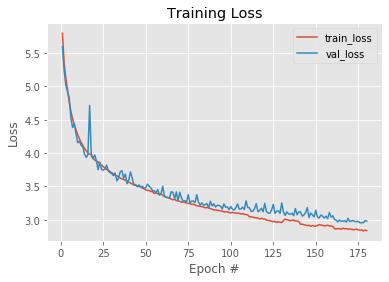

In [ ]:
import pandas as pd
hist = pd.read_csv('models/hist.csv')
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(hist['epoch'], hist["train_loss"], label="train_loss")
plt.plot(hist['epoch'], hist["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluate

In [10]:
def eval_APs_mAP(model, valset_loader):
    '''
    '''
    model.eval()
    detected_boxes = list()
    detected_labels = list()
    detected_scores = list()
    true_boxes = list()
    true_labels = list()
    #true_diffs = list()
    
    with torch.no_grad():
        for step, (imgs, boxes, labels, diffs) in enumerate(valset_loader):
            # move input data to GPU
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            #diffs = [d.to(device) for d in diffs]

            # detect objects
            predicted_offsets, predicted_scores = model(imgs)
            batch_det_boxes, batch_det_labels, batch_det_scores = model.post_process_top_k(predicted_offsets, predicted_scores,
                                                                                      score_threshold=0.02, iou_threshold=0.45, top_k=200)
            detected_boxes.extend(batch_det_boxes)
            detected_labels.extend(batch_det_labels)
            detected_scores.extend(batch_det_scores)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            #true_diffs.extend(diffs)

        # calculate metrics value
        detected_boxes_np = [i.cpu().numpy() for i in detected_boxes]
        detected_labels_np = [i.cpu().numpy() for i in detected_labels]
        detected_scores_np = [i.cpu().numpy() for i in detected_scores]
        true_boxes_np = [i.cpu().numpy() for i in true_boxes]
        true_labels_np = [i.cpu().numpy() for i in true_labels]
        result = eval_detection_voc(detected_boxes_np, detected_labels_np, detected_scores_np, true_boxes_np, true_labels_np)
    
    return result['ap'], result['map']

In [11]:
APs, mAP = eval_APs_mAP(MySSD300, dataloaders['val'])

In [12]:
print(APs)
print(mAP)

[       nan 0.81479036 0.73364865 0.5306327  0.53027352 0.21496273
 0.76149855 0.75267531 0.70828376 0.39961025 0.4568629  0.56387578
 0.6202117  0.70312984 0.76439393 0.79807236 0.30911132 0.56542905
 0.59467395 0.75979598 0.59232853]
0.6087130582935387


## Compare post_process_top_k() and my_post_process() with precision/recall curve

In [13]:
import matplotlib.pyplot as plt
from eval_detection_voc import calc_detection_voc_prec_rec

def cal_prec_rec(det_boxes, det_labels, det_scores, true_boxes, true_labels):
    det_boxes_np = [i.cpu().numpy() for i in det_boxes]
    det_labels_np = [i.cpu().numpy() for i in det_labels]
    det_scores_np = [i.cpu().numpy() for i in det_scores]
    true_boxes_np = [i.cpu().numpy() for i in true_boxes]
    true_labels_np = [i.cpu().numpy() for i in true_labels]
    
    precision, recall = calc_detection_voc_prec_rec(det_boxes_np, det_labels_np, det_scores_np, true_boxes_np, true_labels_np)
    precision = np.array([precision[i][-1] for i in range(1,21)])
    recall = np.array([recall[i][-1] for i in range(1,21)])
    return precision, recall

def plot_prec_rec(my_pp_prec, my_pp_rec, other_pp_prec, other_pp_rec):
    #prec and rec are measured in all 20 classes and I just gonna plot the mean
    my_prec_mean = [i.mean() for i in my_pp_prec]
    my_rec_mean = [i.mean() for i in my_pp_rec]
    other_prec_mean = [i.mean() for i in other_pp_prec]
    other_rec_mean = [i.mean() for i in other_pp_rec]
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(my_rec_mean, my_prec_mean, label="my_post_process()")
    plt.plot(other_rec_mean, other_prec_mean, label="post_process_top_k()")
    plt.title("Precision/Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

In [14]:
all_predicted_offsets = list()
all_predicted_scores = list()
true_boxes = list()
true_labels = list()

MySSD300.eval()
with torch.no_grad():
    for step, (imgs, boxes, labels, diffs) in enumerate(dataloaders['val']):
        imgs = imgs.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        predicted_offsets, predicted_scores = MySSD300(imgs)
        all_predicted_offsets.append(predicted_offsets)
        all_predicted_scores.append(predicted_scores)
        true_boxes.extend(boxes)
        true_labels.extend(labels)
        if step == 31: break #only evaluate on 2048 images in the valset
        
    all_predicted_offsets = torch.cat(all_predicted_offsets, dim=0)
    all_predicted_scores = torch.cat(all_predicted_scores, dim=0)

In [15]:
all_predicted_offsets.shape

torch.Size([2048, 8732, 4])

In [18]:
# my post processing result
my_pp_prec, my_pp_rec, my_pp_run_time = [], [], []

with torch.no_grad():
    for score_threshold in np.arange(0.3, 0.95, 0.03):
        start_time = time.time()
        det_boxes, det_labels, det_scores = MySSD300.my_post_process(all_predicted_offsets, all_predicted_scores,
                                                                    score_threshold, iou_threshold=0.45, top_k=200)
        end_time = time.time()-start_time
        my_pp_run_time.append(round(end_time,2))
        prec, rec = cal_prec_rec(det_boxes, det_labels, det_scores, true_boxes, true_labels)
        my_pp_prec.append(prec)
        my_pp_rec.append(rec)
    print(my_pp_run_time)
    print('my_post_process() average running time:', sum(my_pp_run_time)/len(my_pp_run_time))

[3.85, 4.04, 3.97, 4.15, 4.17, 4.26, 4.53, 4.6, 4.72, 4.59, 4.72, 5.12, 4.94, 5.21, 5.25, 5.44, 5.77, 6.87, 7.52, 10.17, 17.27, 26.54]
my_post_process() average running time: 6.713636363636363


In [20]:
# post processing result as in the paper
other_pp_prec, other_pp_rec, other_pp_run_time = [], [], []

with torch.no_grad():
    for score_threshold in np.arange(0.05, 0.50, 0.02):
        start_time = time.time()
        det_boxes, det_labels, det_scores = MySSD300.post_process_top_k(all_predicted_offsets, all_predicted_scores,
                                                                        score_threshold, iou_threshold=0.45, top_k=200)
        end_time = time.time()-start_time
        other_pp_run_time.append(round(end_time,2))
        prec, rec = cal_prec_rec(det_boxes, det_labels, det_scores, true_boxes, true_labels)
        other_pp_prec.append(prec)
        other_pp_rec.append(rec)
    print(other_pp_run_time)
    print('post_process_top_k() average running time:', sum(other_pp_run_time)/len(other_pp_run_time))

[17.21, 14.17, 12.35, 11.52, 10.71, 10.28, 9.97, 9.47, 9.56, 9.33, 9.14, 9.04, 9.1, 9.2, 8.73, 8.78, 8.8, 8.69, 8.69, 8.58, 8.53, 8.44, 8.35]
post_process_top_k() average running time: 9.94086956521739


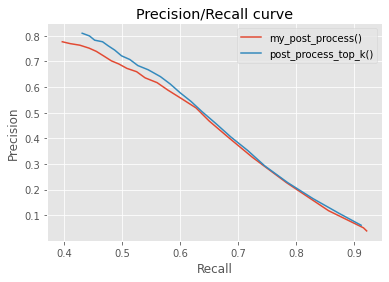

In [21]:
plot_prec_rec(my_pp_prec, my_pp_rec, other_pp_prec, other_pp_rec)

So as it turns out, my approach for post processing wasn't really precise. However, it did got a little faster running time. <br>
I'll use the threshold that results in >0.7 precision and >0.5 recall

In [27]:
threshold_id = 16
print(other_pp_prec[threshold_id].mean(), other_pp_rec[threshold_id].mean())
print('thresholdvalue:', np.arange(0.05, 0.50, 0.02)[threshold_id])

0.7219624554230952 0.49839080026698435
thresholdvalue: 0.37000000000000005
